## CS 476 A3 Q5
#### Jeongseop Yi (Patrick), j22yi

#### a)

$$
\begin{align*}
E[J] &= E[e^y] \\
     &= \int^{\infty}_{-\infty} e^y \cdot f(y) dy \\
     &= \int^{\infty}_{-\infty} e^y \cdot (p_u \mu_u e^{-\mu_u y} 1_{y>=0} + (1 - p_u)\mu_d e^{\mu_d y} 1_{y<0})dy \\
     &= \int^{\infty}_{0} e^y p_u \mu_u e^{-\mu_u y} dy + \int^{0}_{-\infty} e^y (1 - p_u)\mu_d e^{\mu_d y} dy \\
     &= p_u \mu_u [\frac{1}{1-\mu_u} e^{(1-\mu_u)y}]^{\infty}_{0} + (1-p_u)\mu_d [\frac{1}{\mu_d + 1}e^{(\mu_d+1)y}]^{0}_{-\infty} \\ 
     &= p_u \mu_u [\frac{1}{1-\mu_u} (0 - 1)] + (1-p_u)\mu_d [\frac{1}{\mu_d + 1}e^{(\mu_d+1)y}]^{0}_{-\infty}     (\because \mu_u > 1, 1 - \mu_u < 0)\\
     &= \frac{p_u \mu_u}{\mu_u - 1} + (1-p_u)\mu_d [\frac{1}{\mu_d + 1} (1 - 0)] \\
     &= \frac{p_u \mu_u}{\mu_u - 1} + \frac{(1-p_u)\mu_d}{\mu_d + 1}
\end{align*}
$$

Therefore, we have
$$ 
\begin{align*}
E(J - 1) &= E(J) - 1 \\ 
&=\frac{p_u \mu_u}{\mu_u - 1} + \frac{(1-p_u)\mu_d}{\mu_d + 1} - 1
\end{align*}
$$

#### b)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [3]:
def butterflyPayoff(S, K1, K3):
    K2 = (K1 + K3) / 2
    if np.isnan(S):
        return np.nan
    if S > K1 and S < K2:
        return S - K1
    elif S > K2 and S < K3:
        return K3 - S
    else:
        return 0
    
def MC_stock(S0, r, sigma, T, N, M, pu, uu, ud, lm):
    dt = T / N
    X = np.zeros((M, N + 1))
    X[:, 0] = np.log(S0)
    kappa = np.exp((pu*uu) / (uu - 1) + (1-pu)*ud / (ud + 1) - 1)
    drift = (r - 0.5 * (sigma ** 2) - lm * kappa) 
    jump_check = np.zeros(M)
    jump_size = np.zeros(M)
    jump_mask = np.zeros(M)

    for i in range(1, N + 1):
        jump_check = np.random.uniform(0, 1, M)
        jump_mask = np.where(jump_check <= lm * dt, 1, 0)
        upjump_check = np.random.uniform(0, 1, M)
        jump_size = np.where(upjump_check < pu, np.random.exponential(1/uu, M), 
                             -np.random.exponential(1/ud, M))
        jump_size = jump_size * jump_mask

        X[:, i] = X[:, i - 1] + drift * dt + sigma * np.sqrt(dt) \
            * np.random.normal(0, 1, M) + jump_size
    return np.exp(X)

def Butterfly(S0, r, sigma, pu, uu, ud, lm, K1, K3, T, N, M):
    S = MC_stock(S0, r, sigma, T, N, M, pu, uu, ud, lm)
    payoff = list(map(lambda x: butterflyPayoff(x, K1, K3), S[:, -1]))
    return np.mean(payoff) * np.exp(-r * T)

The `MC_stock` is a function which returns a stock price matrix from a double exponential jump model MC simulation. 

The function structure is the same except for the addition of the jump simulation.

To do the jump simulation, it is done using the log prices of the stocks $X_i = \text{log}(S_i)$. 

The jump is determined by the uniform distribution and if a jump occurs then upjump or downjump is determined by uniform distribution. 
The jump size of the jump is determined by two exponential distribution, one for upjump with mean $\mu_u$ and one for downjump with mean $\mu_d$. 

Using Ito's lemma, the next value of $X_{i+1}$ is determined by $X_{i+1} = X_{i} + (r - \frac{\sigma^2}{2} - \lambda \kappa)dt + \sigma \sqrt{dt} \cdot \phi + j$ where $j$ a jumpsize vector calculated above.

In [4]:
# parameters
sigma = 0.15
r = 0.05
T = 1
S0 = 1
K1 = 0.9
K3 = 1.1
uu = 3.04
ud = 3.08
pu = 0.34
lm = 0.1
N = 800
M = 25000

K1_list = np.arange(0.6, 0.91, 0.1)
K3_list = 2*S0 - K1_list
K3_K1 = (K3_list - K1_list) / 2
value_df = pd.DataFrame()
value_df.index.name = "(K3 - K1) / 2"
for i in range(len(K1_list)):
    value_df.loc[K3_K1[i], 'Butterfly'] = \
        Butterfly(S0, r, sigma, pu, uu, ud, lm, K1_list[i], K3_list[i], T, N, M)

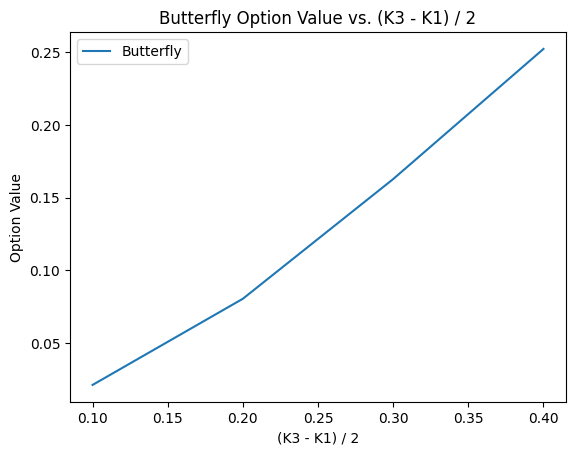

,Butterfly
(K3 - K1) / 2,
0.4,0.252444
0.3,0.162866
0.2,0.080499
0.1,0.021185


In [10]:
sns.lineplot(data=value_df)
plt.title("Butterfly Option Value vs. (K3 - K1) / 2")
plt.xlabel("(K3 - K1) / 2")
plt.ylabel("Option Value")
plt.show()
display(value_df)

As the $\frac{K_3 - K_1}{2}$ value decreases, the butterfly option value decreases. This is expected as the gap between $K_3$ and $K_1$ decreases, it is more likely for the stock prices to be out of bounds to have value at expiry. 

#### c)

In [6]:
def call_and_butterfly(S0, r, sigma, pu, uu, ud, lm, K1, K3, T, N, M):
    S = MC_stock(S0, r, sigma, T, N, M, pu, uu, ud, lm)
    payoff = list(map(lambda x: butterflyPayoff(x, K1, K3), S[:, -1]))
    call_payoff = list(map(lambda x: max(x - K1, 0), S[:, -1]))
    return np.mean(payoff) * np.exp(-r * T), np.mean(call_payoff) * np.exp(-r * T)

The function `call_and_butterfly` calculates the value of butterfly option and call option from a MC-simulated stock prices from the double exponential jump process. 
The value is calculated by applying payoff functions for each option and taking the mean of the payoff with depreciation.

In [7]:
K1_list = np.linspace(0.7, 1.2, 20)
K3_list = np.ones(len(K1_list)) * np.inf

value_dfc = pd.DataFrame()
for i in range(len(K1_list)):
    call, butterfly = \
        call_and_butterfly(S0, r, sigma, pu, uu, ud, lm, K1_list[i], K3_list[i], T, N, M)
    value_dfc.loc[K1_list[i], 'Butterfly'] = butterfly
    value_dfc.loc[K1_list[i], 'Call'] = call

Butterfly and call option values are calculated using the same stock prices from a MC simulation defined in b).

The option values for butterfly and call options are the same when $K_3$ is $\infty$ as given the table.

In [8]:
import py_vollib
from py_vollib.black_scholes  import black_scholes as bs
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv

def iv_try_catch(P, S0, K, T, r, flag):
    try:
        return iv(P, S0, K, T, r, flag)
    except:
        return np.nan

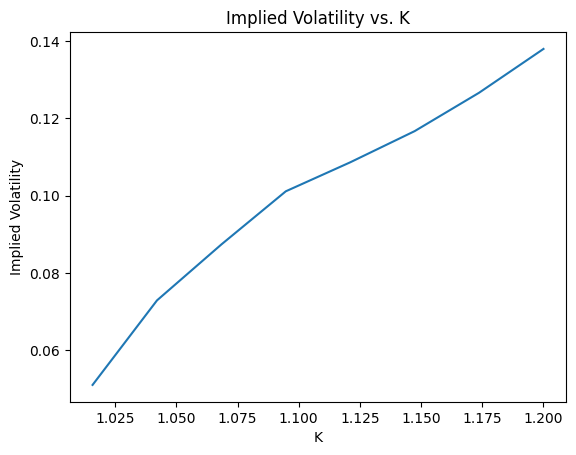

,Butterfly,Call,Implied Volatility
0.700000,0.244462,0.244462,NaN
0.726316,0.219943,0.219943,NaN
0.752632,0.201159,0.201159,NaN
0.778947,0.175682,0.175682,NaN
0.805263,0.153905,0.153905,NaN
0.831579,0.136459,0.136459,NaN
0.857895,0.113375,0.113375,NaN
0.884211,0.099627,0.099627,NaN
0.910526,0.083938,0.083938,NaN
0.936842,0.069095,0.069095,NaN


In [9]:
value_dfc['Implied Volatility'] = \
    list(map(lambda x, y: iv_try_catch(x, S0, y, T, r, 'c'), 
             value_dfc['Butterfly'], K1_list))

sns.lineplot(data=value_dfc['Implied Volatility'])
plt.title("Implied Volatility vs. K")
plt.xlabel("K")
plt.ylabel("Implied Volatility")
plt.show()
display(value_dfc)

#### d)

Due to the jumps, the option values does not have any implied volatility as the option values are less than  intrinsic value when the strike prices are less than S0. 

However, when the strike prices are bigger than S0, the implied volatility of the option increases. 